# LSTM Model

## Website link

In [74]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
data = pd.read_csv('/Users/darshmac/Documents/Cdac Project/Agartala_combined_data.csv')
data.head()

,Date,T2M,T2MDEW,T2MWET,PS,PSC,WS2M,QV2M,RH2M,PRECTOTCORR
0,2004010106,11.97,11.30,11.63,101.33,101.51,0.43,8.24,95.50,0.0
1,2004010107,12.95,11.55,12.25,101.41,101.60,0.33,8.36,91.00,0.0
2,2004010108,15.06,11.97,13.51,101.49,101.67,0.07,8.61,81.62,0.0
3,2004010109,19.23,11.73,15.48,101.56,101.74,0.49,8.48,61.62,0.0
4,2004010110,21.79,11.19,16.48,101.50,101.68,0.60,8.18,50.81,0.0


In [76]:
data.tail()

,Date,T2M,T2MDEW,T2MWET,PS,PSC,WS2M,QV2M,RH2M,PRECTOTCORR
175315,2024010101,15.17,14.13,14.65,101.20,101.38,1.27,10.01,93.69,0.0
175316,2024010102,14.68,14.28,14.48,101.18,101.36,1.33,10.07,97.56,0.0
175317,2024010103,14.21,14.21,14.21,101.18,101.36,1.26,10.13,100.00,0.0
175318,2024010104,13.77,13.77,13.77,101.21,101.39,1.21,10.13,100.00,0.0
175319,2024010105,13.40,13.40,13.40,101.26,101.44,1.09,10.13,100.00,0.0


In [77]:
# Drop the last 6 rows from the main DataFrame
data = data.iloc[:-6]

In [78]:
data.tail()

,Date,T2M,T2MDEW,T2MWET,PS,PSC,WS2M,QV2M,RH2M,PRECTOTCORR
175309,2023123119,20.90,13.58,17.24,101.20,101.37,0.98,9.58,62.50,0.0
175310,2023123120,19.62,13.70,16.66,101.23,101.41,1.11,9.64,68.19,0.0
175311,2023123121,18.37,13.80,16.08,101.24,101.42,1.15,9.70,74.31,0.0
175312,2023123122,17.34,13.87,15.60,101.25,101.43,1.14,9.77,79.81,0.0
175313,2023123123,16.54,13.90,15.22,101.20,101.38,1.14,9.83,84.38,0.0


In [79]:
# Create a new DataFrame with the last 744 rows and drop them from the main DataFrame
last_month_rows = data.iloc[-744:]
data = data.iloc[:-744]

In [80]:
data.tail()

,Date,T2M,T2MDEW,T2MWET,PS,PSC,WS2M,QV2M,RH2M,PRECTOTCORR
174565,2023113019,21.91,16.82,19.37,101.19,101.37,1.06,11.78,72.38,0.0
174566,2023113020,21.50,16.54,19.02,101.28,101.46,1.02,11.60,73.00,0.0
174567,2023113021,21.12,16.33,18.73,101.30,101.48,0.96,11.41,73.75,0.0
174568,2023113022,20.69,16.20,18.44,101.31,101.48,0.91,11.35,75.12,0.0
174569,2023113023,20.08,16.11,18.10,101.26,101.44,0.91,11.29,77.62,0.0


In [81]:
last_month_rows.head()

,Date,T2M,T2MDEW,T2MWET,PS,PSC,WS2M,QV2M,RH2M,PRECTOTCORR
174570,2023120100,19.43,16.06,17.75,101.21,101.39,0.93,11.29,80.69,0.0
174571,2023120101,18.71,16.09,17.40,101.17,101.35,0.96,11.29,84.69,0.0
174572,2023120102,18.07,16.17,17.12,101.14,101.32,0.98,11.41,88.69,0.0
174573,2023120103,17.54,16.26,16.90,101.15,101.33,0.99,11.47,92.31,0.0
174574,2023120104,17.13,16.32,16.73,101.14,101.32,1.01,11.54,95.06,0.0


In [82]:
last_month_rows.tail()

,Date,T2M,T2MDEW,T2MWET,PS,PSC,WS2M,QV2M,RH2M,PRECTOTCORR
175309,2023123119,20.90,13.58,17.24,101.20,101.37,0.98,9.58,62.50,0.0
175310,2023123120,19.62,13.70,16.66,101.23,101.41,1.11,9.64,68.19,0.0
175311,2023123121,18.37,13.80,16.08,101.24,101.42,1.15,9.70,74.31,0.0
175312,2023123122,17.34,13.87,15.60,101.25,101.43,1.14,9.77,79.81,0.0
175313,2023123123,16.54,13.90,15.22,101.20,101.38,1.14,9.83,84.38,0.0


In [83]:
# convert the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d%H')

# print the resulting DataFrame
print(data)

                      Date    T2M  T2MDEW  T2MWET      PS     PSC  WS2M  \
0      2004-01-01 06:00:00  11.97   11.30   11.63  101.33  101.51  0.43   
1      2004-01-01 07:00:00  12.95   11.55   12.25  101.41  101.60  0.33   
2      2004-01-01 08:00:00  15.06   11.97   13.51  101.49  101.67  0.07   
3      2004-01-01 09:00:00  19.23   11.73   15.48  101.56  101.74  0.49   
4      2004-01-01 10:00:00  21.79   11.19   16.48  101.50  101.68  0.60   
...                    ...    ...     ...     ...     ...     ...   ...   
174565 2023-11-30 19:00:00  21.91   16.82   19.37  101.19  101.37  1.06   
174566 2023-11-30 20:00:00  21.50   16.54   19.02  101.28  101.46  1.02   
174567 2023-11-30 21:00:00  21.12   16.33   18.73  101.30  101.48  0.96   
174568 2023-11-30 22:00:00  20.69   16.20   18.44  101.31  101.48  0.91   
174569 2023-11-30 23:00:00  20.08   16.11   18.10  101.26  101.44  0.91   

         QV2M   RH2M  PRECTOTCORR  
0        8.24  95.50          0.0  
1        8.36  91.00       

In [84]:
data

,Date,T2M,T2MDEW,T2MWET,PS,PSC,WS2M,QV2M,RH2M,PRECTOTCORR
0,2004-01-01 06:00:00,11.97,11.30,11.63,101.33,101.51,0.43,8.24,95.50,0.0
1,2004-01-01 07:00:00,12.95,11.55,12.25,101.41,101.60,0.33,8.36,91.00,0.0
2,2004-01-01 08:00:00,15.06,11.97,13.51,101.49,101.67,0.07,8.61,81.62,0.0
3,2004-01-01 09:00:00,19.23,11.73,15.48,101.56,101.74,0.49,8.48,61.62,0.0
4,2004-01-01 10:00:00,21.79,11.19,16.48,101.50,101.68,0.60,8.18,50.81,0.0
...,...,...,...,...,...,...,...,...,...,...
174565,2023-11-30 19:00:00,21.91,16.82,19.37,101.19,101.37,1.06,11.78,72.38,0.0
174566,2023-11-30 20:00:00,21.50,16.54,19.02,101.28,101.46,1.02,11.60,73.00,0.0
174567,2023-11-30 21:00:00,21.12,16.33,18.73,101.30,101.48,0.96,11.41,73.75,0.0
174568,2023-11-30 22:00:00,20.69,16.20,18.44,101.31,101.48,0.91,11.35,75.12,0.0


# Dataset Overview

#### In this section, we will load the dataset and take a preliminary look at its structure and contents.

In [85]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174570 entries, 0 to 174569
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         174570 non-null  datetime64[ns]
 1   T2M          174570 non-null  float64       
 2   T2MDEW       174570 non-null  float64       
 3   T2MWET       174570 non-null  float64       
 4   PS           174570 non-null  float64       
 5   PSC          174570 non-null  float64       
 6   WS2M         174570 non-null  float64       
 7   QV2M         174570 non-null  float64       
 8   RH2M         174570 non-null  float64       
 9   PRECTOTCORR  174570 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 13.3 MB
None


In [86]:
data.describe()

,T2M,T2MDEW,T2MWET,PS,PSC,WS2M,QV2M,RH2M,PRECTOTCORR
count,174570.000000,174570.000000,174570.000000,174570.000000,174570.000000,174570.000000,174570.000000,174570.000000,174570.000000
mean,25.306453,20.171105,22.738776,100.504104,100.678801,1.715763,15.728503,76.321242,0.268617
std,5.460088,6.335299,5.267519,0.543173,0.546065,1.019928,5.428998,19.781645,0.728106
min,3.680000,-2.840000,2.040000,98.360000,98.530000,0.010000,3.050000,8.380000,0.000000
25%,22.440000,15.110000,18.920000,100.070000,100.250000,0.990000,10.620000,64.690000,0.000000
50%,26.210000,22.430000,24.760000,100.510000,100.690000,1.390000,16.970000,81.000000,0.000000
75%,28.900000,25.650000,26.780000,100.950000,101.130000,2.270000,20.690000,93.620000,0.200000
max,41.850000,29.020000,31.410000,101.980000,102.170000,9.720000,25.450000,100.000000,26.680000


In [87]:
data.columns

Index(['Date', 'T2M', 'T2MDEW', 'T2MWET', 'PS', 'PSC', 'WS2M', 'QV2M', 'RH2M',
       'PRECTOTCORR'],
      dtype='object')

# Attempt to fit model

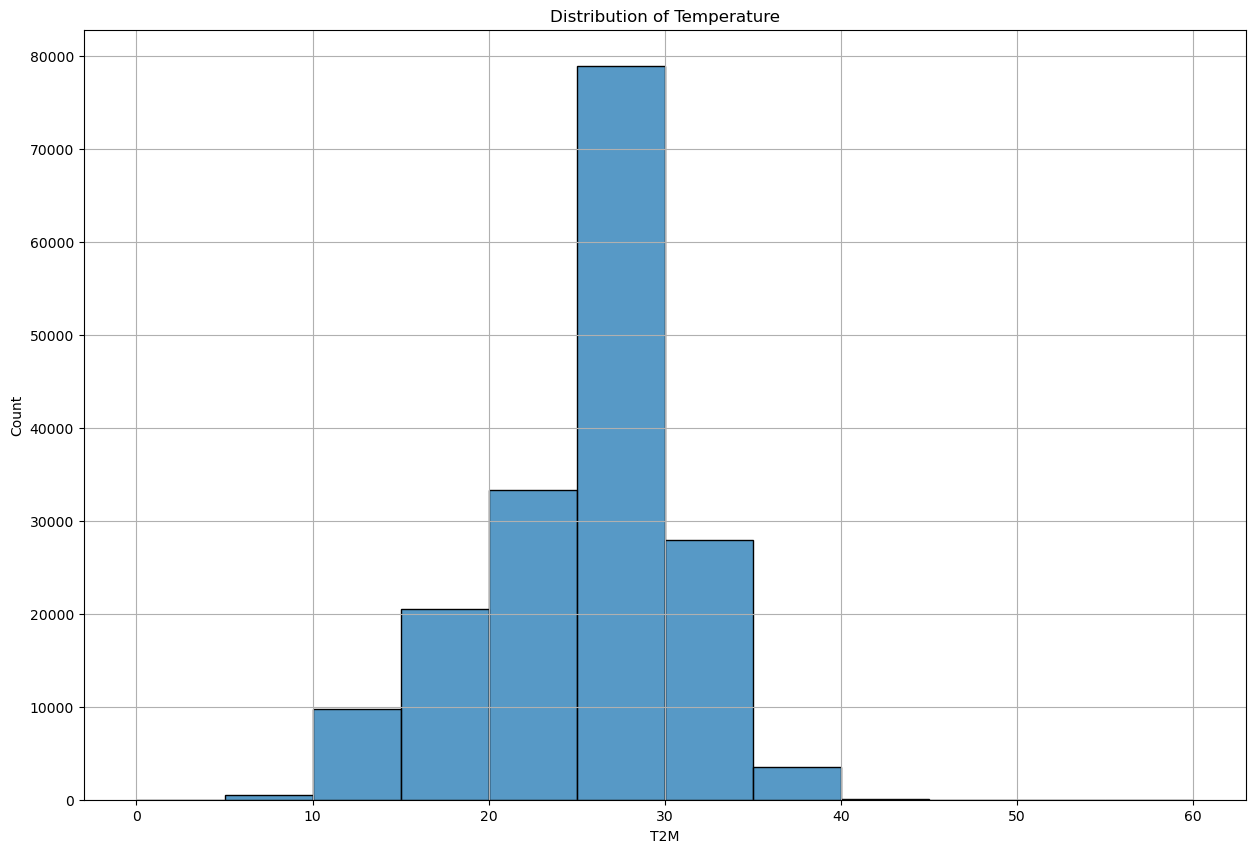

In [88]:
plt.figure(figsize=(15,10))
sns.histplot(data.T2M,bins=[i for i in range(0,61,5)],kde=False)
plt.title("Distribution of Temperature")
plt.grid()
plt.show()

temperature mostly in the range 25 to 30 centigrate

In [89]:
data.index = data['Date']

In [90]:
data.head()

,Date,T2M,T2MDEW,T2MWET,PS,PSC,WS2M,QV2M,RH2M,PRECTOTCORR
Date,,,,,,,,,,
2004-01-01 06:00:00,2004-01-01 06:00:00,11.97,11.30,11.63,101.33,101.51,0.43,8.24,95.50,0.0
2004-01-01 07:00:00,2004-01-01 07:00:00,12.95,11.55,12.25,101.41,101.60,0.33,8.36,91.00,0.0
2004-01-01 08:00:00,2004-01-01 08:00:00,15.06,11.97,13.51,101.49,101.67,0.07,8.61,81.62,0.0
2004-01-01 09:00:00,2004-01-01 09:00:00,19.23,11.73,15.48,101.56,101.74,0.49,8.48,61.62,0.0
2004-01-01 10:00:00,2004-01-01 10:00:00,21.79,11.19,16.48,101.50,101.68,0.60,8.18,50.81,0.0


In [91]:
data.isnull().sum()

Date           0
T2M            0
T2MDEW         0
T2MWET         0
PS             0
PSC            0
WS2M           0
QV2M           0
RH2M           0
PRECTOTCORR    0
dtype: int64

In [92]:
# Rename columns
old_columns = ['T2M','T2MDEW','T2MWET','PS','PSC','WS2M','QV2M','RH2M','PRECTOTCORR']
new_columns = ['Temp2m','Dew2m','Wet_bulb_temp2m','Surface_pressure','Corrected_atm_pressure','Wind_speed2m','Specific_humidity2m','Relative_humidity2m','Precipitation_corrected']
columns_mapping = dict(zip(old_columns, new_columns))
data = data.rename(columns=columns_mapping)

# Temperature Prediction
from correlation matrix we observed Surface pressure ,Corrected_atm_pressure,Relative_humidity2m have negative correlation hence we can drop them

In [93]:
#dropping 
not_req_col = ['Corrected_atm_pressure','Precipitation_corrected']
data = data.drop(columns=not_req_col)
data.head()

,Date,Temp2m,Dew2m,Wet_bulb_temp2m,Surface_pressure,Wind_speed2m,Specific_humidity2m,Relative_humidity2m
Date,,,,,,,,
2004-01-01 06:00:00,2004-01-01 06:00:00,11.97,11.30,11.63,101.33,0.43,8.24,95.50
2004-01-01 07:00:00,2004-01-01 07:00:00,12.95,11.55,12.25,101.41,0.33,8.36,91.00
2004-01-01 08:00:00,2004-01-01 08:00:00,15.06,11.97,13.51,101.49,0.07,8.61,81.62
2004-01-01 09:00:00,2004-01-01 09:00:00,19.23,11.73,15.48,101.56,0.49,8.48,61.62
2004-01-01 10:00:00,2004-01-01 10:00:00,21.79,11.19,16.48,101.50,0.60,8.18,50.81


In [94]:
data.isnull().sum()
#data =data.fillna(method='ffill')

Date                   0
Temp2m                 0
Dew2m                  0
Wet_bulb_temp2m        0
Surface_pressure       0
Wind_speed2m           0
Specific_humidity2m    0
Relative_humidity2m    0
dtype: int64

In [95]:
#Daily Data
daily_data = data.resample('D').mean()
daily_data

/var/folders/yp/tcxqwqns2w52l01lkcdwsy6w0000gn/T/ipykernel_14471/2042967529.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_data = data.resample('D').mean()


,Temp2m,Dew2m,Wet_bulb_temp2m,Surface_pressure,Wind_speed2m,Specific_humidity2m,Relative_humidity2m
Date,,,,,,,
2004-01-01,18.082222,11.385556,14.735000,101.312222,0.823333,8.308333,67.335556
2004-01-02,16.062083,11.107083,13.585417,101.339167,1.327500,8.144583,75.190417
2004-01-03,15.257083,9.621250,12.438333,101.428750,1.260417,7.376667,72.449167
2004-01-04,14.245000,8.644167,11.445417,101.433750,1.522917,6.898750,72.211250
2004-01-05,14.408333,8.368333,11.387083,101.467500,1.540833,6.755000,70.745417
...,...,...,...,...,...,...,...
2023-11-26,22.372500,18.121250,20.245417,101.299167,1.140000,12.875417,77.879167
2023-11-27,22.540417,17.685417,20.112917,101.186250,1.156250,12.616250,76.424167
2023-11-28,23.502083,18.175417,20.838333,100.997500,0.868333,12.922917,73.752500


In [ ]:
#Monthly Data
monthly_data = data.resample('M').mean()
monthly_data

In [ ]:
#Yearly Data
yearly_data = data.resample('Y').mean()
yearly_data

# Normalisation

In [96]:
from sklearn.preprocessing import MinMaxScaler

In [97]:
# Extract and set aside the datetime column
datetime_column = data['Date']
data = data.drop(columns=['Date'])

In [106]:
#Normalise Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [107]:
# # Combine the scaled data with the datetime column
# scaled_data_with_datetime = pd.DataFrame(scaled_data, columns=data.columns)
# scaled_data_with_datetime['Date'] = datetime_column

In [108]:
# scaled_data_with_datetime.head()

# Sequencing Data (12 hours)

In [109]:
#Define sequence(will be taking 12 hours)
sequence_length = 12 #number of steps in each sequence

#Features
num_features = len(data.columns)

In [110]:
#Create sequence and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length]
    label = scaled_data[i+sequence_length][0] #'T2M' column index
    sequences.append(seq)
    labels.append(label)

In [111]:
#Converting to numpy array(because pandas need in numpy array)
sequences = np.array(sequences)
labels = np.array(labels)

In [112]:
#Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x,test_x = sequences[:train_size], sequences[train_size:]
train_y,test_y = labels[:train_size],labels[train_size:]


In [113]:
print("Train X shape : ", train_x.shape)
print("Train Y shape : ", train_y.shape)
print("Test X shape: ", test_x.shape)
print("Test y shape: ", test_y.shape)

Train X shape :  (139646, 12, 7)
Train Y shape :  (139646,)
Test X shape:  (34912, 12, 7)
Test y shape:  (34912,)


# LSTM model

In [114]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [115]:
#Create LSTM model
model = Sequential()

In [116]:
#Adding LSTM with dropout
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

In [117]:
#Add a dense outpu layer
model.add(Dense(units=1))

In [118]:
#Complie the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [119]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 128)           69632     
                                                                 
 dropout_6 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 12, 64)            49408     
                                                                 
 dropout_7 (Dropout)         (None, 12, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1', monitor='val_loss', save_best_only=True)

#Train the model
history = model.fit(
train_x, train_y,
epochs=50,
batch_size=64,
validation_split=0.3,
callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
1528/1528 [==============================] - ETA: 0s - loss: 0.0063

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 78s 46ms/step - loss: 0.0063 - val_loss: 4.0964e-04
Epoch 2/50
1527/1528 [============================>.] - ETA: 0s - loss: 0.0015

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 69s 45ms/step - loss: 0.0015 - val_loss: 3.8948e-04
Epoch 3/50
1527/1528 [============================>.] - ETA: 0s - loss: 7.0981e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 70s 46ms/step - loss: 7.0971e-04 - val_loss: 1.8552e-04
Epoch 4/50
1528/1528 [==============================] - 58s 38ms/step - loss: 5.2619e-04 - val_loss: 2.1306e-04
Epoch 5/50
1528/1528 [==============================] - ETA: 0s - loss: 4.7698e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 69s 45ms/step - loss: 4.7698e-04 - val_loss: 1.7101e-04
Epoch 6/50
1528/1528 [==============================] - 56s 37ms/step - loss: 4.5366e-04 - val_loss: 3.1319e-04
Epoch 7/50
1528/1528 [==============================] - 57s 37ms/step - loss: 4.3090e-04 - val_loss: 2.0980e-04
Epoch 8/50
1527/1528 [============================>.] - ETA: 0s - loss: 4.1333e-04

INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


INFO:tensorflow:Assets written to: /Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1/assets


1528/1528 [==============================] - 68s 45ms/step - loss: 4.1329e-04 - val_loss: 1.3691e-04
Epoch 9/50
1528/1528 [==============================] - 54s 35ms/step - loss: 4.0061e-04 - val_loss: 1.6676e-04
Epoch 10/50
 729/1528 [=============>................] - ETA: 24s - loss: 3.9351e-04

In [ ]:
#Evaluate the best model on the test set
import tensorflow as tf
best_model = tf.keras.models.load_model('/Users/darshmac/Documents/Cdac Project/CDAC-Project/last_check.h1')
test_loss = best_model.evaluate(test_x,test_y)
print("Test Loss: ",test_loss)

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')

# Add a vertical line at the epoch where early stopping occurred
if early_stopping.stopped_epoch is not None:
    plt.axvline(x=early_stopping.stopped_epoch, color='r', linestyle='--', label='Early Stopping')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


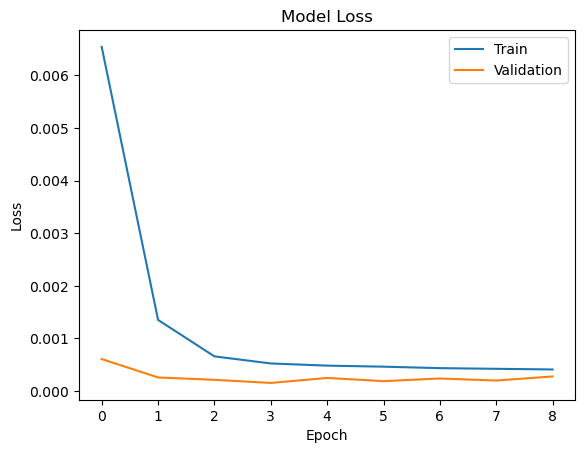

In [57]:
# #Polt training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc ='upper right')
# plt.show()

In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = best_model.predict(test_x)

mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE) :", mae)
print("Mean Squared Error (MSE) :", mse)
print("Root Mean Squared Error (MAE) :", rmse)

1096/1096 [==============================] - 11s 10ms/step
Mean Absolute Error (MAE) : 0.008301977902415438
Mean Squared Error (MSE) : 0.00016674523690463915
Root Mean Squared Error (MAE) : 0.012912987141039023


### Conversion of data to actual data (inverse transformation)

In [68]:
test_y_copies = np.repeat(test_y.reshape(-1,1), test_x.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copies)[:,0]

#Predicted values
prediction = best_model.predict(test_x)
prediction_copies = np.repeat(prediction, 5, axis=1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,0]

1096/1096 [==============================] - 10s 9ms/step


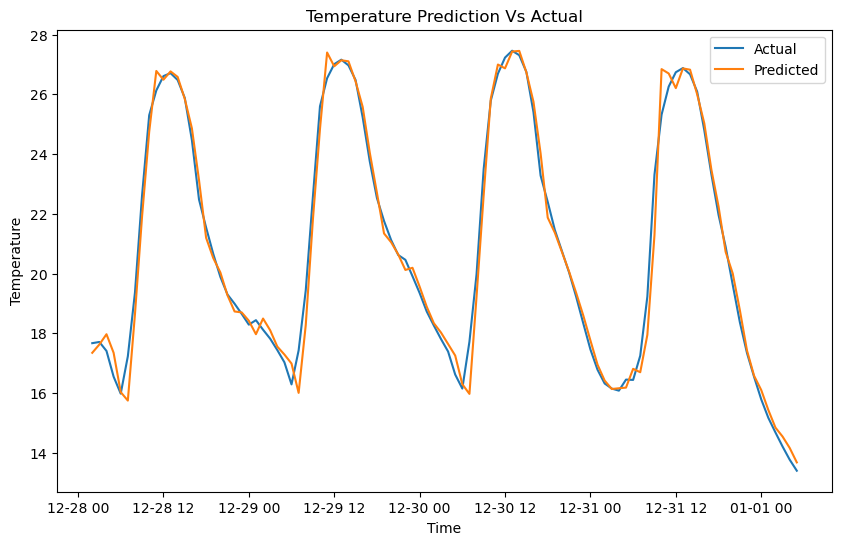

In [69]:
plt.figure(figsize=(10,6))
plt.plot(data.index[-100:], true_temp[-100:], label='Actual')
plt.plot(data.index[-100:], predicted_temp[-100:], label='Predicted')
plt.title('Temperature Prediction Vs Actual')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()